In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import string
import matplotlib.pyplot as plt
import time

Text Encoding

In [2]:
def normalize_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def create_vocab(texts):
    tokens = []
    for text in texts:
        normalized_text = normalize_text(text)
        tokens.extend(normalized_text.split())
    vocab = list(set(tokens))
    vocab.append('<PAD>')
    vocab.append('<UNK>')
    vocab_size = len(vocab)

    token_to_idx = {token: idx for idx, token in enumerate(vocab)}
    idx_to_token = {idx: token for token, idx in token_to_idx.items()}

    return token_to_idx, idx_to_token, vocab_size

def encode_text(texts, token_to_idx, seq_len):
    pad_idx = token_to_idx['<PAD>']
    unk_idx = token_to_idx['<UNK>']
    sequences = []
    for text in texts:
        normalized_text = normalize_text(text)
        tokenized = normalized_text.split()
        encoded = []
        for token in tokenized:
            # Use UNK token for unknown words
            encoded.append(token_to_idx.get(token, unk_idx))
        if len(encoded) > seq_len:
            encoded = encoded[:seq_len]
        else:
            encoded += [pad_idx] * (seq_len - len(encoded))
        sequences.append(encoded)
    return torch.LongTensor(sequences)

Transformer architecture

In [3]:
class ScaledDotProductAttention(nn.Module):
    def forward(self, Q, K, V, mask=None):
        d_k = Q.size(-1)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn = torch.softmax(attn_scores, dim=-1)
        return torch.matmul(attn, V)

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert embed_size % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        self.q_linear = nn.Linear(embed_size, embed_size)
        self.k_linear = nn.Linear(embed_size, embed_size)
        self.v_linear = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)
        self.attention = ScaledDotProductAttention()

    def split_heads(self, x):
        batch_size, seq_length, embed_size = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, _, _ = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.q_linear(Q))
        K = self.split_heads(self.k_linear(K))
        V = self.split_heads(self.v_linear(V))

        out = self.attention(Q, K, V, mask)
        out = self.combine_heads(out)

        return self.fc_out(out)

class FeedForward(nn.Module):
    def __init__(self, embed_size, hidden_dim):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(embed_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embed_size)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x)))

class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len=50):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * -(math.log(10000.0) / embed_size))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))
        self.max_len = max_len

    def forward(self, x):
        seq_len = x.size(1)
        if seq_len > self.max_len:
            position = torch.arange(0, seq_len, dtype=torch.float, device=x.device).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, x.size(-1), 2, device=x.device).float() *
                               -(math.log(10000.0) / x.size(-1)))

            pe = torch.zeros(1, seq_len, x.size(-1), device=x.device)
            pe[0, :, 0::2] = torch.sin(position * div_term)
            pe[0, :, 1::2] = torch.cos(position * div_term)
            return x + pe
        else:
            return x + self.pe[:, :seq_len]

class EncoderLayer(nn.Module):
    def __init__(self, embed_size, num_heads, hidden_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(embed_size, num_heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.ff = FeedForward(embed_size, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        return self.norm2(x + self.dropout(ff_output))

class DecoderLayer(nn.Module):
    def __init__(self, embed_size, num_heads, hidden_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(embed_size, num_heads)
        self.cross_attn = MultiHeadAttention(embed_size, num_heads)
        self.ff = FeedForward(embed_size, hidden_dim)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.norm3 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        return self.norm3(x + self.dropout(ff_output))

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, hidden_dim, num_layers, seq_len):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, seq_len)
        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(embed_size, num_heads, hidden_dim) for _ in range(num_layers)]
        )
        self.decoder_layers = nn.ModuleList(
            [DecoderLayer(embed_size, num_heads, hidden_dim) for _ in range(num_layers)]
        )
        self.fc_out = nn.Linear(embed_size, vocab_size)
        self.dropout = nn.Dropout(0.1)

    def generate_mask(self, src, tgt, device):
        src_len = src.size(1)
        tgt_len = tgt.size(1)

        src_mask = (src != token_to_idx['<PAD>']).unsqueeze(1).unsqueeze(2)
        tgt_mask = torch.triu(torch.ones(tgt_len, tgt_len) == 1).transpose(0, 1)
        tgt_mask = tgt_mask.float().masked_fill(tgt_mask == 0, float('-inf')).masked_fill(tgt_mask == 1, float(0.0))

        return src_mask.to(device), tgt_mask.to(device)

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt, src.device)

        src = self.dropout(self.positional_encoding(self.embedding(src)))
        enc_output = src
        for layer in self.encoder_layers:
            enc_output = layer(enc_output, src_mask)

        tgt = self.dropout(self.positional_encoding(self.embedding(tgt)))
        dec_output = tgt
        for layer in self.decoder_layers:
            dec_output = layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc_out(dec_output)
        return output

    def generate(self, prompt, max_length=50, temperature=1.0, top_k=5):
      self.eval()
      with torch.no_grad():
          if len(prompt.shape) == 1:
              src = prompt.unsqueeze(0)
          else:
              src = prompt

          generated = src[:, :1]
          for _ in range(max_length):
              output = self.forward(src, generated)
              next_token_logits = output[:, -1, :] / temperature

              probs = torch.softmax(next_token_logits, dim=-1)

              top_k_probs, top_k_indices = torch.topk(probs, min(top_k, probs.size(-1)))
              next_token_idx = torch.multinomial(top_k_probs, 1)
              next_token = top_k_indices.gather(1, next_token_idx)

              if next_token.item() == token_to_idx['<PAD>']:
                  break

              generated = torch.cat([generated, next_token], dim=1)
              if generated.size(1) >= max_length:
                  break

      return generated.squeeze(0)

Training set up

In [9]:
texts = [
    "Hello, how are you? I'm doing well, thank you.",
    "Hi there! How’s it going? It’s going great, thanks for asking!",
    "Good morning! How have you been? I’ve been good, thank you.",
    "Hey! What’s new with you? Not much, just the usual.",
    "Hello! How’s everything on your end? All is well, thank you for asking.",
    "Hi! It’s great to see you. How’s life treating you? Life’s been pretty good lately!",
    "Hey there! How’s your day going? It’s going smoothly, thanks!",
    "Good afternoon! How’s it going? It’s going well, hope you’re good too!",
    "Hello! Hope you’re doing well. I am, thanks for checking in!",
    "Hey! How’s your week been so far? It’s been productive, thank you!",
    "Good to see you! How are things? Things are good, thanks for asking!",
    "Hi! Hope everything is good with you. Yes, everything’s fine here, thank you!",
    "Hello! How are you feeling today? I’m feeling great, thanks for asking.",
    "Hey! It’s been a while. How are you? I’m doing well, how about you?",
    "Good day! How have things been with you? Things have been going well, thank you.",
    "Hello! What have you been up to lately? Just working on a few projects, thanks for asking.",
    "Hey! Hope you’re having a good day. I am, thank you!",
    "Hi! What’s been going on? Just the usual, nothing new here.",
    "Hello! How’s work or school treating you? It’s going well, thanks for asking!",
    "Hey there! How’s your morning (or afternoon) going? It’s going great so far, thanks!",
    "Hi! How’s everything? Everything’s good, thank you for asking.",
    "Hello! How’s life these days? Life’s been busy but good, thanks!",
    "Hey there! How are you today? I’m doing really well, how about you?",
    "Good morning! How are things going for you? They’re going well, thanks!",
    "Hi there! How’s your day treating you? It’s treating me well, thank you!",
    "Hello! How has your week been? It’s been a good week, thanks for asking.",
    "Hey! How’s everything going? All good here, how about you?",
    "Good to see you! How’s it been lately? It’s been good, thanks for checking in.",
    "Hello! How’s your mood today? I’m in a great mood, thank you!",
    "Hi! How are things on your side? Things are looking up, thanks!",
    "Hey! How’s the family? They’re doing well, thank you for asking.",
    "Good afternoon! How’s your schedule been? It’s been packed, but good!",
    "Hello! How have you been keeping? I’ve been well, thanks for asking.",
    "Hi there! What’s been keeping you busy? Just a mix of work and hobbies, thanks!",
    "Hey! Hope you’re feeling well today. I am, thank you so much!",
    "Good to see you! How have things been? Things have been wonderful, thank you.",
    "Hello! How are you finding the weather? It’s been lovely, thanks for asking!",
    "Hi! How’s the day so far? The day’s been great, hope yours is too!",
    "Hey there! How’s your spirit today? Feeling good, thanks for asking!",
    "Good day! How’s the energy today? I’m full of energy, thank you!",
    "Hello! What’s new with you today? Just getting through some work, thanks!",
    "Hello, how are you? I'm doing well, thank you.",
    "Hi there, how are you? It’s going great, thanks for asking!",
    "Hey, how are you? I'm good, thanks for checking in!",
    "Hi, how are you today? I'm doing well, how about you?",
    "Hello, how are you doing? I'm doing just fine, thanks!",
    "Hey, how are you feeling? Everything's going great, thanks!",
    "Hi, how are you today? I'm feeling good, thanks for asking.",
    "Hello, how are you? I'm doing well, thanks!",
    "Hey, how are you? I'm doing well, how about you?",
    "Hi, how are you doing? It’s been good, thanks!",
    "I've been learning to play guitar lately, it's challenging but fun",
    "The weather has been unusually warm for this time of year",
    "Did you catch the game last night? It was incredible!",
    "Hello, how are you? I am good thank you.",
    "Hi, how are you? I'm doing well, thanks for asking!",
    "How was your weekend? It was great, I went hiking with some friends and saw an amazing sunset.",
    "Do you know any good restaurants around here? Yes, theres this amazing Italian place down the street.",
    "Can you help me with this math problem? Of course, Id be happy to help. What are you working on?",
    "What time is the meeting tomorrow? The meeting starts at 2 PM in the main conference room.",
    "What are your plans for the holidays? Im planning to visit my family and do some skiing in Colorado.",
    "The weather is beautiful today. I know, perfect for a picnic in the park.",
    "How long have you been working here? I started about three years ago in the marketing department.",
    "This project is really challenging. Yes, but I think were making good progress.",
    "Did you finish the report? Almost done, I just need to add the charts and proofread it one more time.",
    "The traffic was terrible this morning. I know what you mean, I had to take an alternate route to avoid the construction.",
    "Hi, how's your day going? Pretty good, just finished a big project at work.",
    "What did you have for breakfast today? I had oatmeal with fresh berries and honey.",
    "Have you seen any good movies lately? Yes, I just watched 'Inception' and it was amazing.",
    "Where did you grow up? I grew up in a small town near Boston.",
    "Do you play any musical instruments? Yes, I've been playing guitar for about five years.",
    "What's your favorite season? I love autumn because of the beautiful colors and crisp air.",
    "Could you pass me that pen? Here you go, I hope it writes well.",
    "How long have you been working here? About three years now, time really flies.",
    "What's your favorite type of cuisine? I really love Thai food, especially pad thai.",
    "Did you catch the game last night? Yes, it was such an exciting match!",
    "How do you like your coffee? I prefer it black with just a splash of milk.",
    "What time does the meeting start? It starts at 2 PM in the conference room.",
    "Have you tried the new cafe downtown? Yes, their croissants are absolutely delicious.",
    "What are your plans for the weekend? I'm planning to do some gardening and catch up on reading.",
    "Can you recommend a good book? I just finished 'The Alchemist' and couldn't put it down.",
    "Do you have any pets? Yes, I have a cat named Luna who's very playful.",
    "What's the weather like today? It's sunny with a light breeze, perfect for a walk.",
    "How was your vacation? It was wonderful, I spent a week at the beach.",
    "Are you going to the party on Saturday? Yes, I'm really looking forward to it.",
    "What's your favorite hobby? I love photography, especially taking nature shots.",
    "Do you speak any other languages? I'm fluent in Spanish and learning Japanese.",
    "How was the concert? It was fantastic, the band played all their best songs.",
    "What did you think of the presentation? It was very informative and well-organized.",
    "Have you ever been to Paris? Yes, I visited last summer and fell in love with the city.",
    "What's your favorite ice cream flavor? I can't resist chocolate chip mint.",
    "Did you finish the report? Yes, I just sent it to your email.",
    "How do you get to work? I usually take the subway, it's faster than driving.",
    "What's your favorite TV show? I'm really into 'The Crown' right now.",
    "Can you help me with directions? Of course, where are you trying to go?",
    "How long have you been studying English? I've been learning for about two years now.",
    "What's your ideal vacation? I'd love to go hiking in the mountains and stay in a cozy cabin.",
    "Have you tried the new recipe? Yes, it turned out really well, I'll share it with you.",
    "What time should we meet tomorrow? Let's meet at noon at the usual spot.",
    "Do you live nearby? Yes, just a few blocks away from here.",
    "How was your doctor's appointment? Everything went well, thanks for asking.",
    "What kind of music do you like? I enjoy all kinds, but especially jazz and classical.",
    "Have you started your Christmas shopping? Yes, I'm trying to get it done early this year.",
    "What's your favorite part of your job? I love collaborating with creative people.",
    "Do you have any siblings? Yes, I have an older brother and a younger sister.",
    "How was your dinner? It was delicious, the chef really outdid himself."
]

token_to_idx, idx_to_token, vocab_size = create_vocab(texts)
seq_len = 20
encoded_sequences = encode_text(texts, token_to_idx, seq_len)

Model training

Epoch 10, Avg Loss: 3.1505
Epoch 20, Avg Loss: 1.6458
Epoch 30, Avg Loss: 0.7709
Epoch 40, Avg Loss: 0.3508
Epoch 50, Avg Loss: 0.1487
Time taken: 271.3544 seconds


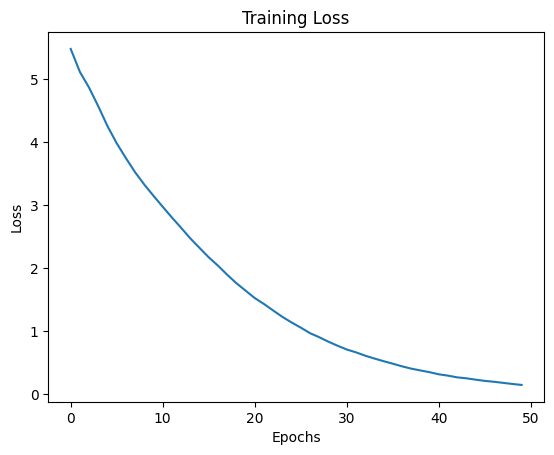

In [68]:
embed_size = 256
num_heads = 8
hidden_dim = 256
num_layers = 8
batch_size = 4
num_epochs = 50
learning_rate = 0.00005

model = TransformerModel(vocab_size, embed_size, num_heads, hidden_dim, num_layers, seq_len)
criterion = nn.CrossEntropyLoss(ignore_index=token_to_idx['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_values = []
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    num_batches = len(encoded_sequences) // batch_size + 1

    for i in range(0, len(encoded_sequences), batch_size):
        batch_sequences = encoded_sequences[i:i+batch_size]
        if len(batch_sequences) < batch_size:
            continue

        x_train = batch_sequences
        y_train = torch.roll(batch_sequences, -1, dims=1)
        y_train[:, -1] = token_to_idx['<PAD>']

        optimizer.zero_grad()
        output = model(x_train, x_train)
        loss = criterion(output.view(-1, vocab_size), y_train.view(-1))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    loss_values.append(avg_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")

end_time = time.time()  # Record the end time of the epoch
epoch_duration = end_time - start_time
print(f"Time taken: {epoch_duration:.4f} seconds")

plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

Generated text

In [69]:
def generate_text(model, prompt_text, token_to_idx, idx_to_token, seq_len, max_length=8):
    prompt = encode_text([prompt_text], token_to_idx, seq_len)
    generated_sequence = model.generate(prompt[0], max_length=max_length, temperature=0.7, top_k=5)
    generated_text = []
    for idx in generated_sequence:
        token = idx_to_token[idx.item()]
        if token == '<PAD>' or token == '<UNK>':
            continue
        generated_text.append(token)
    return " ".join(generated_text)

# Test the model
prompt_text = "Hi, how you doing"
generated = generate_text(model, prompt_text, token_to_idx, idx_to_token, seq_len)
print(f"Prompt: {prompt_text}")
print(f"Generated: {generated}")

Prompt: Hi, how you doing
Generated: hi there doing well doing well doing well
